<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dsettu/tflite/blob/main/har_ign/CNN_HAR_KERAS.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dsettu/tflite/blob/main/har_ign/CNN_HAR_KERAS.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

*   List item
*   List item



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Upload WISDM_ar_v1.1_raw.txt file from
\STM32CubeFunctionPack_SENSING1_V4.0.2\Utilities\AI_Ressources\Training Scripts\HAR\datasets

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw.txt


In [ ]:
import importlib.util
import sys

# To add a directory with your code into a list of directories 
# which will be searched for packages
sys.path.append('/content/drive/My Drive/Colab Notebooks/HAR')

## Step1 : Import necessary dependencies
Following section imports all the required dependencies. This also sets seeds for random number generators in Numpy and Tensorflow environments to make the results reproducibile.

In [ ]:
import numpy as np
import pandas as pd 

np.random.seed(611)

import argparse, os, logging, warnings
from os.path import isfile, join
from datetime import datetime

# private libraries
from PrepareDataset import DataHelper
from HARNN import ANNModelHandler

# for using callbacks to save the model during training and comparing the results at every epoch
from keras.callbacks import ModelCheckpoint

# disabling annoying warnings originating from Tensorflow
logging.getLogger('tensorflow').disabled = True

import tensorflow as tf
tf.compat.v1.set_random_seed(611)

# disabling annoying warnings originating from python
warnings.simplefilter("ignore")

## Step2: Set environment variables
Following section sets some user variables which will later be used for:

* preparing the dataset.
* preparing the neural networks.
* training the neural networks.
* validating the neural network.

In [ ]:
# data variables
dataset = 'WISDM'
merge = True
segmentLength = 24
stepSize = 24
dataDir = '/content/drive/My Drive/Colab Notebooks/HAR/datasets/ai_logged_data'
preprocessing = True

# neural network variables
modelName = 'IGN'

# training variables
trainTestSplit = 0.6
trainValidationSplit = 0.7
nEpochs = 20
learningRate = 0.0005
decay = 1e-6
batchSize = 64
verbosity = 1
nrSamplesPostValid = 2

## Step3: Result directory
Each run can have different variables and to compare the results of different choices, such as different segment size for the window for data, different overlap settings etc, we need to save the results. Following section creates a result directory to save results for the current run. The name of the directory has following format. `Mmm_dd_yyyy_hh_mm_ss_dataset_model_seqLen_stepSize_epochs_results`, and example name for directory can be `Oct_24_2019_14_31_20_WISDM_IGN_24_16_20_results`, which shows the process was started at October 24, 2019, at 14:31:20, the dataset used was WISDM, with segment size = 24, segment step = 16, and Nr of epochs = 20.

In [ ]:
# if not already exist create a parent directory for results.
if not os.path.exists( './results/'):
    os.mkdir( './results/' )
resultDirName = 'results/{}/'.format(datetime.now().strftime( "%Y_%b_%d_%H_%M_%S" ) )
os.mkdir( resultDirName )
infoString = 'runTime : {}\nDatabase : {}\nNetwork : {}\nSeqLength : {}\nStepSize : {}\nEpochs : {}\n'.format( datetime.now().strftime("%Y-%b-%d at %H:%M:%S"), dataset, modelName, segmentLength, stepSize, nEpochs )
with open( resultDirName + 'info.txt', 'w' ) as text_file:
    text_file.write( infoString )

In [ ]:
print(resultDirName)

results/2020_Oct_20_11_12_06/


## Step4: Create a `DataHelper` object
The script in the following section creates a `DataHelper` object to preprocess, segment and split the dataset as well as to create one-hot-code labeling for the outputs to make the data training and testing ready using the choices set by the user in **Step2**.

In [ ]:
myDataHelper = DataHelper( dataset = dataset, loggedDataDir = dataDir, merge = merge,
                            modelName = modelName, seqLength = segmentLength, seqStep = stepSize,
                            preprocessing = preprocessing, trainTestSplit = trainTestSplit,
                            trainValidSplit = trainValidationSplit, resultDir = resultDirName )

## Step5: Prepare the dataset
Following section prepares the dataset and create six tensors namely `TrainX`, `TrainY`, `ValidationX`, `ValidationY`, `TestX`, `TestY`. Each of the variables with trailing `X` are the inputs with shape `[_, segmentLength, 3, 1 ]`and each of the variables with trailing `Y` are corresponding outputs with shape `[ _, NrClasses ]`. `NrClasses` for `WISDM` can be `4` or `6` and for `AST` is `5`.

In [ ]:
TrainX, TrainY, ValidationX, ValidationY, TestX, TestY = myDataHelper.prepare_data()

Segments built :   1%|          | 286/27456 [00:00<00:09, 2856.48 segments/s]

Segmenting Train data


Segments built :   2%|▏         | 299/18304 [00:00<00:06, 2986.41 segments/s]

Segmenting Test data


Segments built : 100%|██████████| 18304/18304 [00:12<00:00, 1520.31 segments/s]


Segmentation finished!
preparing data file from all the files in directory  /content/drive/My Drive/Colab Notebooks/HAR/datasets/ai_logged_data
parsing data from  IoT01-MemsAnn_03_Oct_19_09h_59m_42s.csv
parsing data from  IoT01-MemsAnn_03_Oct_19_09h_58m_33s.csv
parsing data from  IoT01-MemsAnn_03_Oct_19_10h_01m_26s.csv
parsing data from  IoT01-MemsAnn_03_Oct_19_10h_01m_12s.csv
parsing data from  IoT01-MemsAnn_03_Oct_19_10h_00m_36s.csv
parsing data from  IoT01-MemsAnn_03_Oct_19_09h_58m_09s.csv


Segments built : 100%|██████████| 41/41 [00:00<00:00, 1687.15 segments/s]

Segmenting the AI logged Train data
Segmenting the AI logged Test data
Segmentation finished!


## Step6: Create a `ANNModelHandler` object
The script in the following section creates a `ANNModelHandler` object to create, train and validate the <u>A</u>rtificial <u>N</u>eural <u>N</u>etwork (ANN) using the variables created in **Step2**.

In [ ]:
myHarHandler = ANNModelHandler( modelName = modelName, classes = myDataHelper.classes, resultDir = resultDirName,
                              inputShape = TrainX.shape, outputShape = TrainY.shape, learningRate = learningRate,
                              decayRate = decay, nEpochs = nEpochs, batchSize = batchSize,
                              modelFileName = 'har_' + modelName, verbosity = verbosity )

## Step6: Create a ANN model
Following script creates the ANN and prints its summary to show the architecture and nr of parameters for ANN.

In [ ]:
harModel = myHarHandler.build_model()
harModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 3, 24)          408       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 24)          0         
_________________________________________________________________
flatten (Flatten)            (None, 216)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                2604      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 52        
Total params: 3,064
Trainable params: 3,064
Non-trainable params: 0
______________________________________________________

## Step7: Create a Checkpoint for ANN training
The following script creates a check point for the training process of ANN to save the neural network as `h5` file. The settings are used in a way that the validation accuracy `val_acc` is maximized.

In [ ]:
harModelCheckPoint = ModelCheckpoint( filepath = join(resultDirName, 'har_' + modelName + '.h5'),
                                     monitor = 'val_acc', verbose = 0, save_best_only = True, mode = 'max' )

## Step7 : Train the created neural network
The following script trains the created neural network with the provided checkpoint and created datasets.

Epoch 1/20
302/302 [==============================] - 1s 5ms/step - loss: 1.2506 - acc: 0.4700 - val_loss: 0.7400 - val_acc: 0.7063
Epoch 2/20
302/302 [==============================] - 1s 4ms/step - loss: 0.7942 - acc: 0.6800 - val_loss: 0.5783 - val_acc: 0.7911
Epoch 3/20
302/302 [==============================] - 1s 4ms/step - loss: 0.6299 - acc: 0.7582 - val_loss: 0.4704 - val_acc: 0.8168
Epoch 4/20
302/302 [==============================] - 1s 4ms/step - loss: 0.5371 - acc: 0.7862 - val_loss: 0.4090 - val_acc: 0.8433
Epoch 5/20
302/302 [==============================] - 1s 4ms/step - loss: 0.4861 - acc: 0.8068 - val_loss: 0.3783 - val_acc: 0.8634
Epoch 6/20
302/302 [==============================] - 1s 4ms/step - loss: 0.4486 - acc: 0.8274 - val_loss: 0.3510 - val_acc: 0.8712
Epoch 7/20
302/302 [==============================] - 1s 4ms/step - loss: 0.4235 - acc: 0.8399 - val_loss: 0.3341 - val_acc: 0.8797
Epoch 8/20
302/302 [==============================] - 1s 4ms/step - loss: 0.

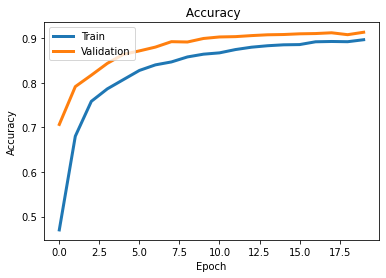

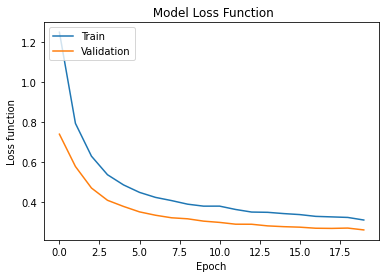

In [ ]:
harModel = myHarHandler.train_model( harModel, TrainX, TrainY, ValidationX, ValidationY, harModelCheckPoint )

## Step8: Validating the trained neural network
The following section validates the created network and creates a confusion matrix for the test dataset to have a detailed picture of the errors.

401/401 [==============================] - 0s 1ms/step
Accuracy for each class is given below.
Jogging     : 95.82 %
Stationary  : 98.87 %
Stairs      : 68.64 %
Walking     : 88.46 %


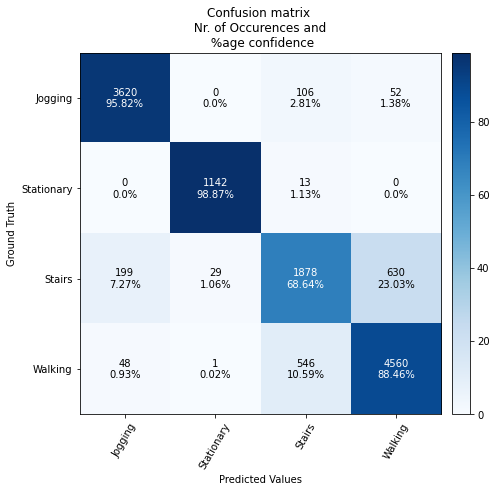

In [ ]:
myHarHandler.make_confusion_matrix( harModel, TestX, TestY )

## Step9: Save Neural Network

In [ ]:
from tensorflow.keras.models import load_model
# Save entire network to HDF5 (save everything, suggested)
harModel.save('har_ign_wisdm.h5')
model = load_model ("har_ign_wisdm.h5")

## Step10: Convert to a TensorFlow Lite model - using integer-only quantization

In [ ]:
def representative_dataset_gen():
    for i in range(len(TrainX)):
      input = TrainX[i].reshape(1,24,3,1)
      input = input.astype(np.float32)
      yield [input]

converter=tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_dataset_gen

# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, 
# we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
# Provide a representative dataset to ensure we quantize correctly.
tflite_model_quant2 = converter.convert()

with open("har_ign_wisdm_quant2.tflite", 'wb') as tflite_file:
    tflite_file.write(tflite_model_quant2)


In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

source_text, header_text = convert_bytes_to_c_source(tflite_model_quant2,  "har_model")

hfile = "/content/drive/My Drive/Colab Notebooks/HAR/har_ign_wisdm_quant2.h"
cfile = "/content/drive/My Drive/Colab Notebooks/HAR/har_ign_wisdm_quant2.cpp"

with  open(hfile,  'w')  as  file:
    file.write(header_text)

with  open(cfile,  'w')  as  file:
    file.write(source_text)

## Step11: Test the model after quantization

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2e8df77400>)

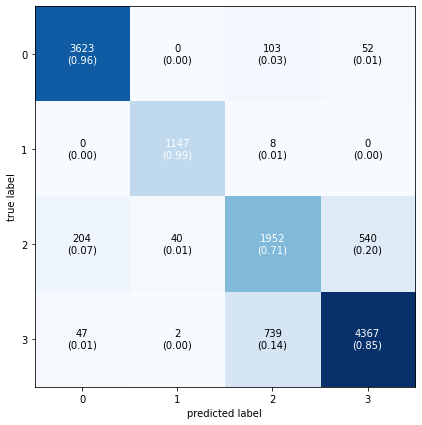

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Initialize an interpreter with the model
interpreter = tf.lite.Interpreter("har_ign_wisdm_quant2.tflite")

# Allocate memory for the model's input Tensor's
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Create arrays to store the results
har_model_predictions = []

# Inference with Tensorflow Lite model
for i in range(len(TestX)):
  tf_input = TestX[i].reshape(1,24,3,1)
  tf_input = tf_input.astype(np.float32)

# Manually quantize the input from float to integer
  scale, zero_point = input_details['quantization']
  tflite_integer_input = tf_input / scale + zero_point
  tflite_integer_input = tflite_integer_input.astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], tflite_integer_input)

  if (i==300):
    sample=tflite_integer_input;

  interpreter.invoke()

  output_details = interpreter.get_output_details()[0]
  tflite_integer_output = interpreter.get_tensor(output_details['index'])
  # Manually dequantize the output from integer to float
  scale, zero_point = output_details['quantization']
  tflite_output = tflite_integer_output.astype(np.float32)
  tflite_output = (tflite_output - zero_point) * scale

  har_model_predictions.append(tflite_output[0])

# Plot Confusion matrix
y_label=tf.argmax(TestY, axis=1)
y_pred=np.argmax(har_model_predictions, axis=1)

  
mat = confusion_matrix(y_label, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

In [ ]:

samplefile = "/content/drive/My Drive/Colab Notebooks/HAR/sample.csv"

with  open(samplefile,  'w')  as  file:
  for i in range(24):
    data=str(sample[0,i,:,:]).replace('[','').replace(']','').replace('\n',',')+","
    file.write(data)
    file.write('\n')


In [ ]:
TestY[300]

array([0., 0., 1., 0.], dtype=float32)

In [ ]:
TrainX.shape

(19285, 24, 3, 1)